In [ ]:
import kagglehub
behrad3d_nasa_cmaps_path = kagglehub.dataset_download('behrad3d/nasa-cmaps')

print('Data source import complete.')

Using Colab cache for faster access to the 'nasa-cmaps' dataset.
Data source import complete.


In [ ]:
# Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Scikit-Learn Imports
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Untuk Baseline

pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

print("Library imported successfully!")

Library imported successfully!


In [ ]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

train_path = '/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt'
test_path = '/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt'
rul_path = '/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt'

# Cek & Load Data
if os.path.exists(train_path):
    # PERBAIKAN: Tambahkan r sebelum '\s+'
    train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=col_names)
    test_df = pd.read_csv(test_path, sep=r'\s+', header=None, names=col_names)
    rul_df = pd.read_csv(rul_path, sep=r'\s+', header=None, names=['RUL'])

    print("Data Loaded Successfully!")
    print(f"Train Shape: {train_df.shape}")
    print(f"Test Shape: {test_df.shape}")
else:
    print("File tidak ditemukan. Pastikan file dataset ada di directory yang sama.")

Data Loaded Successfully!
Train Shape: (20631, 26)
Test Shape: (13096, 26)


In [ ]:
# 1. Hitung Max Cycle per Unit untuk Training Data
max_cycle = train_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_nr', 'max_cycle']

# 2. Gabungkan dan Hitung RUL (Sisa Umur)
train_df = train_df.merge(max_cycle, on='unit_nr', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)

# 3. LABELING
# Jika RUL <= 30 siklus, maka itu ANOMALI (1). Sisanya NORMAL (0).
THRESHOLD = 30
train_df['label'] = train_df['RUL'].apply(lambda x: 1 if x <= THRESHOLD else 0)

# Untuk Data Test
# Hitung RUL untuk data test
max_cycle_test = test_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle_test.columns = ['unit_nr', 'max_cycle']
test_df = test_df.merge(max_cycle_test, on='unit_nr', how='left')

# Ambil True RUL
rul_df['unit_nr'] = rul_df.index + 1
test_df = test_df.merge(rul_df, on='unit_nr', how='left')

# RUL saat ini = True RUL + (Max Cycle Data Test - Cycle Saat Ini)
test_df['RUL_calc'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['time_cycles'])
test_df['label'] = test_df['RUL_calc'].apply(lambda x: 1 if x <= THRESHOLD else 0)

# Cek Distribusi Kelas
print("Distribusi Kelas Training:")
print(train_df['label'].value_counts())
train_df.head()

Distribusi Kelas Training:
label
0    17531
1     3100
Name: count, dtype: int64


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [ ]:
# Pakai Semua Sensor
features_cols = setting_names + sensor_names

# Normalisasi
scaler = MinMaxScaler()
train_df[features_cols] = scaler.fit_transform(train_df[features_cols])
test_df[features_cols] = scaler.transform(test_df[features_cols])

print("Normalisasi Selesai.")
train_df[features_cols].head()

Normalisasi Selesai.


,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


In [ ]:
def gen_sequence(id_df, seq_length, seq_cols):
    """
    Fungsi untuk memotong data menjadi window sequence.
    Hanya mengambil data jika panjang data unit >= seq_length
    """
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    """
    Fungsi untuk mengambil label yang berasosiasi dengan sequence terakhir
    """
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# Konfigurasi Window
SEQUENCE_LENGTH = 80 # Panjang window

# Generate Training Data
X_train, y_train = [], []
for unit in train_df['unit_nr'].unique():
    unit_df = train_df[train_df['unit_nr'] == unit]
    for seq in gen_sequence(unit_df, SEQUENCE_LENGTH, features_cols):
        X_train.append(seq)
    for lbl in gen_labels(unit_df, SEQUENCE_LENGTH, ['label']):
        y_train.append(lbl)

X_train = np.array(X_train)
y_train = np.array(y_train).flatten() # Flatten agar jadi array 1D

print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")

Shape X_train: (12631, 80, 24)
Shape y_train: (12631,)


In [ ]:
X_test = []
y_test = []

for unit in test_df['unit_nr'].unique():
    unit_df = test_df[test_df['unit_nr'] == unit]

    # Ambil sequence terakhir untuk evaluasi
    if len(unit_df) >= SEQUENCE_LENGTH:
        seq = unit_df[features_cols].values[-SEQUENCE_LENGTH:]
        X_test.append(seq)

        # Ambil label dari baris terakhir
        lbl = unit_df['label'].iloc[-1]
        y_test.append(lbl)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_test: (77, 80, 24)
Shape y_test: (77,)


In [ ]:
# Definis Fungsi Model Sebelum Grid Search

def create_model(lstm_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()

    # --- Layer 1: CNN ---
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    # --- Layer 2: LSTM ---
    model.add(LSTM(lstm_units, return_sequences=False, unroll=True))
    model.add(Dropout(dropout_rate))

    # --- Layer 3: Output ---
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

print("Fungsi 'create_model' berhasil dibuat")

Fungsi 'create_model' berhasil dibuat


In [ ]:
# Eksekusi Grid Search
# Sel ini akan melakukan looping untuk mencari kombinasi terbaik.

# 1. Tentukan Kandidat Parameter yang mau diuji
lstm_candidates = [50, 100]       # Coba LSTM dengan 50 unit dan 100 unit
dropout_candidates = [0.2, 0.4]   # Coba Dropout 20% dan 40%

# Variabel penyimpan hasil terbaik
best_acc = 0
best_params = {}

print("Mulai Grid Search...")
print(f"Total kombinasi: {len(lstm_candidates) * len(dropout_candidates)}")
print("="*40)

# 2. Mulai Looping
for units in lstm_candidates:
    for drop in dropout_candidates:
        print(f"\n[Training] Menguji kombinasi: LSTM={units}, Dropout={drop}...")

        # Panggil fungsi
        model = create_model(lstm_units=units, dropout_rate=drop)

        # Latih model
        history = model.fit(
            X_train, y_train,
            epochs=15,             # Jumlah epoch pencarian
            batch_size=64,
            validation_split=0.2,
            verbose=1
        )

        # Ambil akurasi validasi terakhir
        val_acc = history.history['val_accuracy'][-1]
        print(f"--> Hasil Akurasi Validasi: {val_acc:.4f}")

        # Cek apakah ini hasil terbaik?
        if val_acc > best_acc:
            best_acc = val_acc
            best_params = {'lstm_units': units, 'dropout_rate': drop}
            print(f"Hasil Terbaik")

print("\n" + "="*40)
print(f"Grid Search Selesai.")
print(f"Parameter Terbaik: {best_params}")
print(f"Akurasi Terbaik: {best_acc:.4f}")
print("="*40)

Mulai Grid Search...
Total kombinasi: 4

[Training] Menguji kombinasi: LSTM=50, Dropout=0.2...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8148 - loss: 0.3768 - val_accuracy: 0.9537 - val_loss: 0.1134
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9496 - loss: 0.1258 - val_accuracy: 0.9458 - val_loss: 0.1343
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9565 - loss: 0.1096 - val_accuracy: 0.9573 - val_loss: 0.0982
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9581 - loss: 0.0965 - val_accuracy: 0.9632 - val_loss: 0.0945
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9586 - loss: 0.0974 - val_accuracy: 0.9596 - val_loss: 0.0988
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9606 - loss: 0.0862 - val_accuracy: 0.9664 - val_loss: 0.0894
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9653 - loss: 0.0829 - val_accuracy: 0.9581 - val_loss: 0.1030
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9630 - loss: 0.0806 - val_acc

Training Final Model dengan LSTM=50 & Dropout=0.2
Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8225 - loss: 0.3921 - val_accuracy: 0.9486 - val_loss: 0.1189
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9480 - loss: 0.1291 - val_accuracy: 0.9426 - val_loss: 0.1252
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9531 - loss: 0.1108 - val_accuracy: 0.9573 - val_loss: 0.0972
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9585 - loss: 0.0994 - val_accuracy: 0.9600 - val_loss: 0.0919
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9580 - loss: 0.0946 - val_accuracy: 0.9604 - val_loss: 0.0962
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9559 - loss: 0.0968 - val_accuracy: 0.9620 - val_loss: 0.0946
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9623 - loss: 0.0872 - val_accuracy: 0.9640 - val_loss: 0.0903
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33m

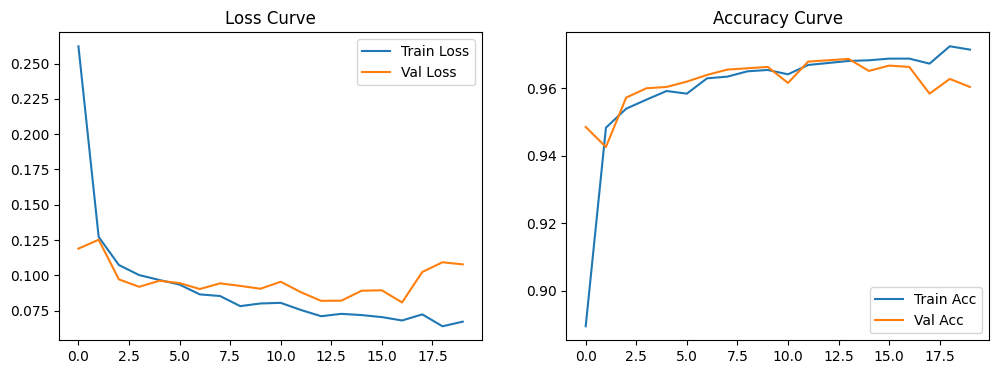

In [ ]:
# Ambil parameter terbaik
final_units = best_params.get('lstm_units', 50)
final_dropout = best_params.get('dropout_rate', 0.2)

print(f"Training Final Model dengan LSTM={final_units} & Dropout={final_dropout}")

# Re-build model bersih
final_model = create_model(lstm_units=final_units, dropout_rate=final_dropout)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_hybrid_model.keras', monitor='val_accuracy', save_best_only=True)

# Full Training
history_final = final_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_final.history['accuracy'], label='Train Acc')
plt.plot(history_final.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


--- HASIL EVALUASI MODEL DEEP LEARNING ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        52
     Anomali       1.00      0.80      0.89        25

    accuracy                           0.94        77
   macro avg       0.96      0.90      0.92        77
weighted avg       0.94      0.94      0.93        77



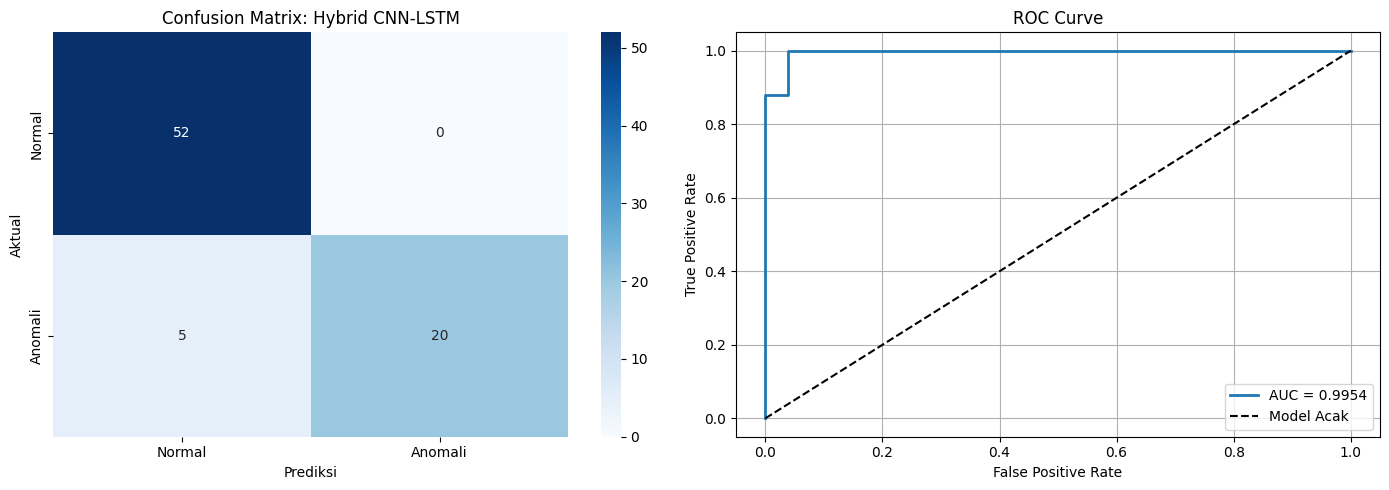

Accuracy  : 0.9351
Precision : 0.9408
Recall    : 0.9351
AUC Score : 0.9954


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- HASIL EVALUASI MODEL DEEP LEARNING ---")

# Prediksi pada data uji
y_pred_prob = final_model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Laporan klasifikasi
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomali']))

# Visualisasi Confusion Matrix dan ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
    xticklabels=['Normal', 'Anomali'],
    yticklabels=['Normal', 'Anomali']
)
ax[0].set_title('Confusion Matrix: Hybrid CNN-LSTM')
ax[0].set_xlabel('Prediksi')
ax[0].set_ylabel('Aktual')

# ROC Curve dan AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score_dl = roc_auc_score(y_test, y_pred_prob)

ax[1].plot(fpr, tpr, label=f'AUC = {auc_score_dl:.4f}', linewidth=2)
ax[1].plot([0, 1], [0, 1], 'k--', label='Model Acak')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc='lower right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"AUC Score : {auc_score_dl:.4f}")

Melatih model baseline (Random Forest)...

--- HASIL EVALUASI RANDOM FOREST ---
              precision    recall  f1-score   support

      Normal       0.88      0.98      0.93        52
     Anomali       0.95      0.72      0.82        25

    accuracy                           0.90        77
   macro avg       0.91      0.85      0.87        77
weighted avg       0.90      0.90      0.89        77



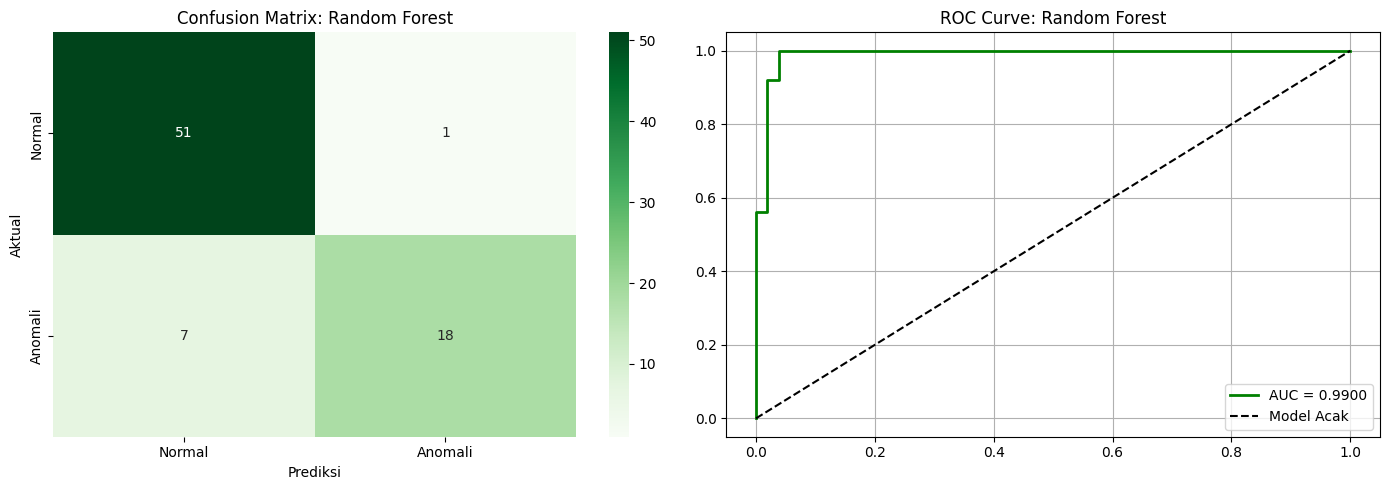

----------------------------------------
RF Accuracy   : 0.8961
RF Precision  : 0.9014
RF Recall     : 0.8961
RF AUC Score  : 0.9900
----------------------------------------
HASIL PERBANDINGAN MODEL
Deep Learning (CNN-LSTM) | Akurasi: 0.9351 | AUC: 0.9954
Baseline (Random Forest) | Akurasi: 0.8961 | AUC: 0.9900
Kesimpulan: Model Deep Learning menunjukkan kinerja yang lebih unggul dibandingkan model baseline.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print("Melatih model baseline (Random Forest)...")

# Persiapan data (Random Forest membutuhkan input 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Pelatihan model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Prediksi dan probabilitas
y_pred_rf = rf_model.predict(X_test_flat)
y_pred_prob_rf = rf_model.predict_proba(X_test_flat)[:, 1]

print("\n--- HASIL EVALUASI RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Anomali']))

# Visualisasi Confusion Matrix dan ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax[0],
    xticklabels=['Normal', 'Anomali'],
    yticklabels=['Normal', 'Anomali']
)
ax[0].set_title('Confusion Matrix: Random Forest')
ax[0].set_xlabel('Prediksi')
ax[0].set_ylabel('Aktual')

# ROC Curve dan AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_score_rf = roc_auc_score(y_test, y_pred_prob_rf)

ax[1].plot(fpr_rf, tpr_rf, label=f'AUC = {auc_score_rf:.4f}', linewidth=2, color='green')
ax[1].plot([0, 1], [0, 1], 'k--', label='Model Acak')
ax[1].set_title('ROC Curve: Random Forest')
ax[1].legend(loc='lower right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

print("-" * 40)
print(f"RF Accuracy   : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"RF Precision  : {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"RF Recall     : {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"RF AUC Score  : {auc_score_rf:.4f}")
print("-" * 40)

# Ringkasan Perbandingan Model
print("=" * 40)
print("HASIL PERBANDINGAN MODEL")
print(f"Deep Learning (CNN-LSTM) | Akurasi: {accuracy_score(y_test, y_pred):.4f} | AUC: {auc_score_dl:.4f}")
print(f"Baseline (Random Forest) | Akurasi: {accuracy_score(y_test, y_pred_rf):.4f} | AUC: {auc_score_rf:.4f}")
print("=" * 40)

if auc_score_dl > auc_score_rf:
    print("Kesimpulan: Model Deep Learning menunjukkan kinerja yang lebih unggul dibandingkan model baseline.")
else:
    print("Kesimpulan: Model baseline menunjukkan kinerja yang sebanding atau lebih baik.")

In [ ]:
# Export TF Lite
import os

print("Memulai Konversi ke TFLite...")

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# Optimasi standar
converter.optimizations = [tf.lite.Optimize.DEFAULT]

try:
    tflite_model = converter.convert()

    # Simpan ke File
    tflite_filename = 'anomaly_detector_model.tflite'
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print("\n" + "="*40)
    if os.path.exists(tflite_filename):
        print(f"SUKSES: Model TFLite tersimpan sebagai '{tflite_filename}'")
        print(f"Ukuran file: {os.path.getsize(tflite_filename) / 1024:.2f} KB")
        print("Model sekarang 100% kompatibel dengan Android & Raspberry Pi.")
    else:
        print("Gagal menyimpan model TFLite.")

except Exception as e:
    print(f"\n ERROR: {str(e)}")

print("="*40)

Memulai Konversi ke TFLite...
Saved artifact at '/tmp/tmproxf8kmn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 24), dtype=tf.float32, name='keras_tensor_406')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140633015000848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015004112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015003536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015000656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015009104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015004304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015002960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015007376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140633015002192: TensorSpec(shape=(), dtype=tf.resource, name=None)

SUKSES: Model TFLite tersimpan sebagai 'anomaly_detector

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive berhasil di-mount!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil di-mount!


Menggunakan folder yang sudah ada: /content/drive/My Drive/Tugas_Akhir_IoT

Menyimpan Confusion Matrix


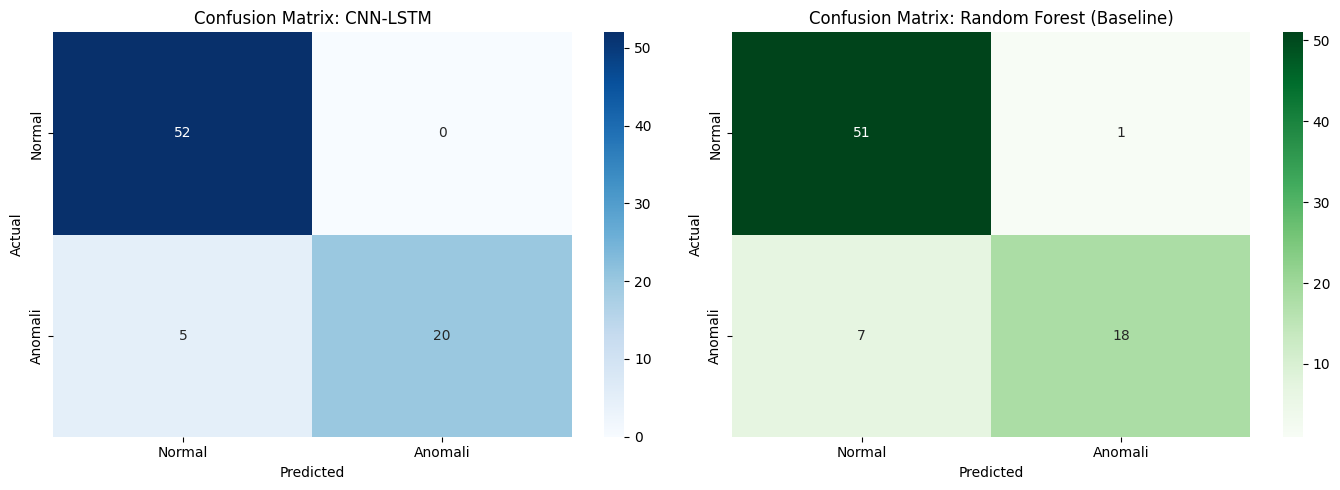

   --> Tersimpan: /content/drive/My Drive/Tugas_Akhir_IoT/confusion_matrices.png

Menyimpan Grafik Training


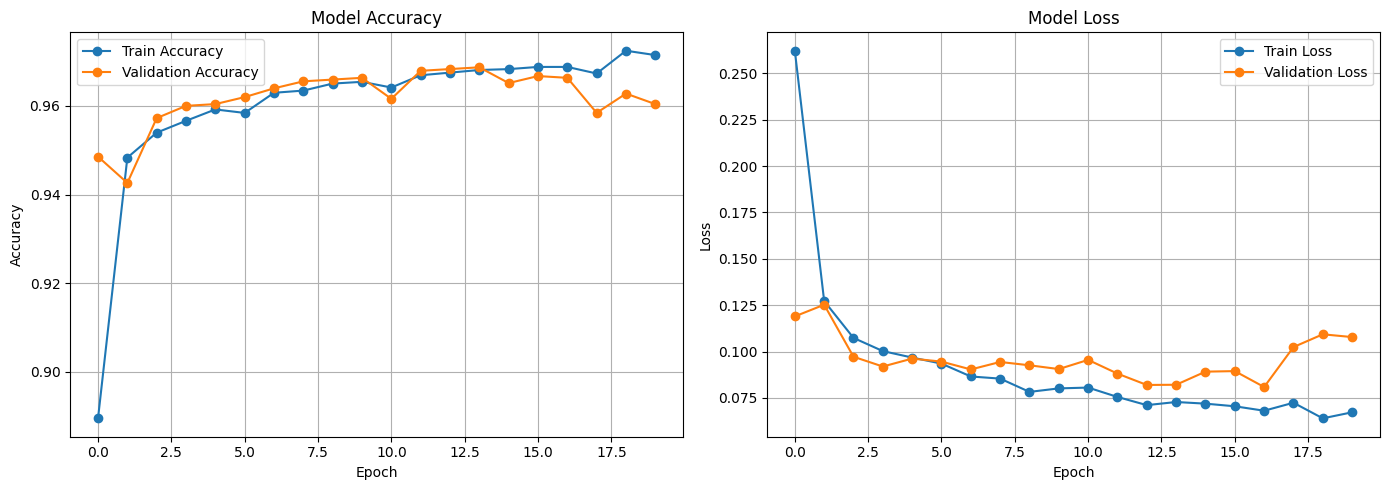

   --> Tersimpan: /content/drive/My Drive/Tugas_Akhir_IoT/training_history.png

Menyimpan ROC Curve dan nilai AUC


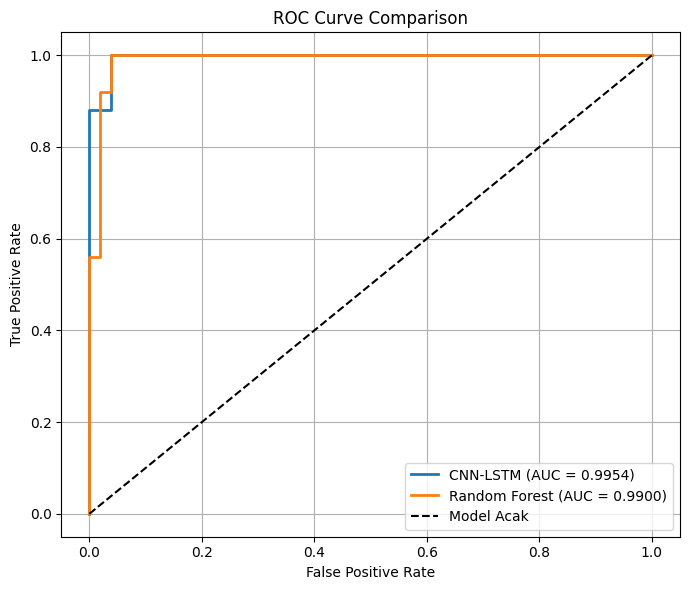

   --> Tersimpan: /content/drive/My Drive/Tugas_Akhir_IoT/roc_curve_comparison.png
   --> Nilai AUC tersimpan: /content/drive/My Drive/Tugas_Akhir_IoT/auc_scores.txt

Menyimpan File Model ke Drive...
   --> Berhasil menyalin: anomaly_detector_model.tflite

Seluruh output tersimpan di folder:
/content/drive/My Drive/Tugas_Akhir_IoT


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Konfigurasi folder penyimpanan di Google Drive
drive_folder = "/content/drive/My Drive/Tugas_Akhir_IoT"

if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)
    print(f"Membuat folder baru di Drive: {drive_folder}")
else:
    print(f"Menggunakan folder yang sudah ada: {drive_folder}")

# SIMPAN CONFUSION MATRIX
print("\nMenyimpan Confusion Matrix")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix CNN-LSTM
cm_dl = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm_dl, annot=True, fmt='d', cmap='Blues', ax=axes[0],
    xticklabels=['Normal', 'Anomali'],
    yticklabels=['Normal', 'Anomali']
)
axes[0].set_title('Confusion Matrix: CNN-LSTM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
    xticklabels=['Normal', 'Anomali'],
    yticklabels=['Normal', 'Anomali']
)
axes[1].set_title('Confusion Matrix: Random Forest (Baseline)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()

cm_filename = os.path.join(drive_folder, "confusion_matrices.png")
plt.savefig(cm_filename, dpi=300)
plt.show()
print(f"   --> Tersimpan: {cm_filename}")


# SIMPAN GRAFIK TRAINING

print("\nMenyimpan Grafik Training")

if 'history_final' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history_final.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history_final.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history_final.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history_final.history['val_loss'], label='Validation Loss', marker='o')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()

    history_filename = os.path.join(drive_folder, "training_history.png")
    plt.savefig(history_filename, dpi=300)
    plt.show()
    print(f"   --> Tersimpan: {history_filename}")
else:
    print("Variabel 'history_final' tidak ditemukan")


# SIMPAN ROC CURVE & AUC

print("\nMenyimpan ROC Curve dan nilai AUC")

fig, ax = plt.subplots(figsize=(7, 6))

# ROC CNN-LSTM
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_prob)
auc_dl = roc_auc_score(y_test, y_pred_prob)
ax.plot(fpr_dl, tpr_dl, label=f'CNN-LSTM (AUC = {auc_dl:.4f})', linewidth=2)

# ROC Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linewidth=2)

# Garis acuan
ax.plot([0, 1], [0, 1], 'k--', label='Model Acak')

ax.set_title('ROC Curve Comparison')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
ax.grid(True)

plt.tight_layout()

roc_filename = os.path.join(drive_folder, "roc_curve_comparison.png")
plt.savefig(roc_filename, dpi=300)
plt.show()
print(f"   --> Tersimpan: {roc_filename}")

# Simpan nilai AUC ke file teks
auc_filename = os.path.join(drive_folder, "auc_scores.txt")
with open(auc_filename, "w") as f:
    f.write("AUC SCORES\n")
    f.write(f"CNN-LSTM       : {auc_dl:.4f}\n")
    f.write(f"Random Forest : {auc_rf:.4f}\n")

print(f"   --> Nilai AUC tersimpan: {auc_filename}")

# SIMPAN FILE MODEL
print("\nMenyimpan File Model ke Drive...")

files_to_save = [
    "anomaly_detector_model.tflite"
]

for file_name in files_to_save:
    if os.path.exists(file_name):
        destination = os.path.join(drive_folder, file_name)
        shutil.copy(file_name, destination)
        print(f"   --> Berhasil menyalin: {file_name}")
    else:
        print(f"   --> File tidak ditemukan: {file_name}")

print("\n" + "=" * 40)
print(f"Seluruh output tersimpan di folder:\n{drive_folder}")
print("=" * 40)


In [ ]:
import pandas as pd
import numpy as np

# Definisi kolom dataset
columns = (
    ['unit_nr', 'time_cycles',
     'setting_1', 'setting_2', 'setting_3'] +
    [f's_{i}' for i in range(1, 22)]
)

# Kolom fitur
feature_cols = (
    ['setting_1', 'setting_2', 'setting_3'] +
    [f's_{i}' for i in range(1, 22)]
)

# Load data test
test_df = pd.read_csv(
    '/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt',
    sep=r'\s+',
    header=None,
    names=columns
)

# Load true RUL
rul_df = pd.read_csv(
    '/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt',
    header=None,
    names=['RUL']
)
rul_df['unit_nr'] = rul_df.index + 1

# Parameter
ENGINE_ID = 4
SEQUENCE_LENGTH = 80
THRESHOLD = 30

# Ambil data engine
engine_data = test_df[test_df['unit_nr'] == ENGINE_ID]

if len(engine_data) >= SEQUENCE_LENGTH:

    # Ambil window terakhir
    input_sequence = engine_data[feature_cols].values[-SEQUENCE_LENGTH:]

    # Normalisasi
    if 'scaler' in globals():
        input_sequence = scaler.transform(input_sequence)

    # Flatten untuk Random Forest
    X_demo_flat = input_sequence.reshape(1, -1)

    # Prediksi model
    prob_rf = rf_model.predict_proba(X_demo_flat)[0][1]
    pred_label = "Anomali" if prob_rf > 0.5 else "Normal"

    # Label Aktual
    max_cycle = engine_data['time_cycles'].max()
    true_rul = rul_df[rul_df['unit_nr'] == ENGINE_ID]['RUL'].values[0]
    current_cycle = engine_data['time_cycles'].iloc[-1]

    rul_actual = true_rul + (max_cycle - current_cycle)
    actual_label = "Anomali" if rul_actual <= THRESHOLD else "Normal"

    # Output
    print("-" * 40)
    print("DEMO INFERENCE DATA UJI")
    print("-" * 40)
    print(f"Engine ID            : {ENGINE_ID}")
    print(f"Window Data          : {SEQUENCE_LENGTH} siklus terakhir")
    print(f"Probabilitas Anomali : {prob_rf:.4f}")
    print(f"Prediksi Model       : {pred_label}")
    print(f"Label Aktual         : {actual_label}")
    print(f"RUL Aktual           : {rul_actual:.0f} siklus")
    print("-" * 40)

else:
    print(f"Engine {ENGINE_ID} memiliki data kurang dari {SEQUENCE_LENGTH} siklus.")


----------------------------------------
DEMO INFERENCE DATA UJI
----------------------------------------
Engine ID            : 4
Window Data          : 80 siklus terakhir
Probabilitas Anomali : 0.4800
Prediksi Model       : Normal
Label Aktual         : Normal
RUL Aktual           : 110 siklus
----------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
